---

# ERGUN Emrullah - Nicolas Tristan 


---

# Generative Adversarial Networks (GANs)

In this lab, we will create a Generative Artificial Network (GAN) to learn to generate artificial images that resembles true images. The objective of the Generator model is to produce images that are similar to “true” images, and the objective of the Discriminator model is the recognise whether a given image is “true” or “fake” (generated). The more the Generator model produces images with better quality, the more the Discriminator model has to be able to distinguish (or classify) “true” and “fake” images. 

#Import the library and load the data set 

You can work with MNIST, fashion MNIST or CIFAR10. In the follows, we consider the MNIST as example.

- Use Keras to load the dataset
- Normalize the x_train pixel data to [-1, 1]
- Reshape x_train to (60000, 784); 60000: number of image in the dataset if you use MNIST, 784 is the number of pixel per image in MNIST. 

NOTE: use GPU

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, Reshape,Embedding,Concatenate,Conv2D,Flatten,Conv2DTranspose,Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
#%reset

##1. GAN with fully-connected layers 

In that case, the Generator model takes as input a vector of size D (lets use D = 100) with Gaussian noise, and outputs an “image” of size 28 × 28 × 1. For that, we need to use the Reshape layer at some point of our model: 

In [ ]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train=2*np.reshape(x_train.astype('float32') / 255.,(60000,784))-1
x_test=np.reshape( x_test.astype('float32') / 255.,(10000,784)) 

x_train.shape,x_test.shape  #Check

((60000, 784), (10000, 784))

2 1


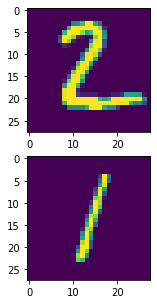

In [ ]:
# For plotting/saving images
# You can plot/save other iamges... 
print (y_test[1], y_test[2])
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax.imshow(x_test[1].reshape((28,28)))
ax2.imshow(x_test[2].reshape((28,28)))
plt.show()


In [ ]:
x_train.min(),x_train.max() #Check

(-1.0, 1.0)


### 1.1. Generator network

Construct a generator network using a sequential model in Keras:
- You can test the following layers
  - 1st layer: a dense layer with 256 nodes, initialize the kernal with normally distributed weights with zero mean and 0.02 standard deviation, Leaky ReLU activation with $alpha=0.2$
  - Then, add some layers with more nodes
  - Output dense layer with size of image
  - Question: what should you use as activation in output layer of G? Why? 
<font color='red'>Activation functions such as ReLU are used to address the vanishing gradient problem in deep convolutional neural networks and promote sparse activations (e.g. lots of zero values).
ReLU is recommended for the generator, but not for the discriminator model. Instead, a variation of ReLU that allows values less than zero, called Leaky ReLU, is preferred in the discriminator.

- Compile the generator using binary crossentropy loss and the Adam optimizer with learning rate 0.0002 and $\beta_1 = 0.5$

In [ ]:
random_dim = 100

G = Sequential()
G.add(Input(shape=( random_dim,)))
G.add(Dense(256,kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),activation=LeakyReLU(alpha=0.2)))
G.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
G.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
G.add(Dense(784, activation='tanh'))
#G.add(Reshape((28, 28, 1)))                                                            
G.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

### 1.2. Discriminator network

Now you can define the Discriminator model (with Dense layers only).

- Hints:
  - Add some dense layers with activation...
  - Use dropout
- Compile the Discriminator model with a loss and Adam optimizer

- Questions : What loss should you use for Discriminator? 
<font color='red'>  The discrminator uses a sigmoid in the output layer. It is a boolean classification problem, and this will ensure the output would be either 0 or 1.
-How many neurons should you use for the output layer of Discriminator? What is the most adapted activation for this case? 
<font color='red'>The generator model takes as input a point in the latent space and outputs a single 28×28 grayscale image. This is achieved by using a fully connected layer to interpret the point in the latent space and provide sufficient activations that can be reshaped into many copies (in this case 128) of a low-resolution version of the output image (e.g. 7×7). 
This is then upsampled twice, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers.
In this case we should use a LeakyReLU activation fonction


In [ ]:
D = Sequential()
D.add(Input(shape=(784,)))
D.add(Dense(1024,kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(0.3))
D.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(0.3))
D.add(Dense(256,activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(0.3))
D.add(Dense(1,activation='sigmoid'))
D.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

### 1.3. Adversarial Network

Now we have our generator and discriminator networks, we can form the GAN graph by creating another network using the functional API of Keras.

- Create a Keras Model that feeds a random noise tensor through the generator, the output of which is fed to the discriminator. Note: use discriminator.trainable = False before constructing the GAN network.
- Compile the GAN with binary cross-entropy loss and same Adam optimizer as before

In [ ]:
# Combined network
D.trainable = False

# TODO*
gan_input = Input(shape=(random_dim,))
gan_output= D(G(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

## 1.4. Training

Finally, for training the GAN (Generator + Discriminator networks), we need to implement a procedure for training on each batch of images individually. In that procedure, we first train the Discriminator network with one batch, then we “freeze” it by setting D.trainable = False, and finally we train the Generative model. 

For each epoch of training, implement the following:
1. Select a random sample of batch_size images from the training dataset (real_images).
2. Compute a normally-distributed (mean 0, variance 1) noise vector with shape = (batch_size, random_dim). This will be used as input to the generator.
3. Use the generator predict function to create batch_size fake images from the noise vectors.
4. Concatenate the samples of real and fake images to form a single array of size (2*batch_size, 784).
5. Construct the labels vector for these samples (2*batch_size).  Label the real images as 0 and the fake images as 0.9.  
6. Use `train_on_batch` to perform one optimization step on the discriminator given the samples of images and labels. Keep track of the loss.
7. Create another noise vector with shape = (batch_size, random_dim).
8. Create a 'labels' vector with shape = (batch_size, 1) of all ones.
9. Use `train_on_batch` to perform one optimization step on the gan model (with a frozen discriminator). This will train the underlying generator model. Keep track of the loss.

Once you have implemented everything, run the cell.  If everything is working correctly, you will see examples of generated examples.

Question : What is the goal of using 0.9 instead of 1 for true images when training the discriminator network? 
<font color='red'>  If the label set for real images is 1, we change it to a lower value, like 0.9. This solution discourages the discriminator from being overconfident about its classification, or in other words from relying on a very limited set of features to determine if an image is real or fake. I completely endorse this little trick as it has shown to work very well in practice and it only requires to change one or two characters in your code.

In [ ]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    images = G.predict(noise)
    images = images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def train(epochs=1, batch_size=128):
    batch_count = x_train.shape[0] / batch_size
    print( 'Epochs:', epochs )
    print( 'Batch size:', batch_size )
    print( 'Batches per epoch:', batch_count )

    for e in range(1, epochs+1):
        print( '-'*15, 'Epoch %d' % e, '-'*15 )
        for _ in range(int(batch_count)):
            # Train discriminator
            # TODO* 1.
            noise =np.random.normal(0,1, size=(batch_size, random_dim))
            
            # TODO* 2.
            real_images = x_train[np.random.randint(0,high=len(x_train),size=batch_size)]

            # TODO* 3. 
            generated_images = G.predict(noise)
            #print(generated_images.shape)
            #print(real_images.shape)

            # TODO* 4.
            images = np.concatenate([real_images, generated_images])

            # TODO* 5.
            labels =np.zeros((2*batch_size,1))
            labels[:batch_size]=0.9

            D.trainable = True
            # TODO* 6.
            D.train_on_batch(images, labels)

            # Train generator
            # TODO* 7.
            noise= np.random.normal(0,1, [batch_size, random_dim])
            
            # TODO* 8.
            labels = np.ones(batch_size)
            
            D.trainable = False
            # TODO* 9.
            gan.train_on_batch(noise, labels)


        # Plot some generated images
        plot_generated_images(e)


train(50, 128)

Output hidden; open in https://colab.research.google.com to view.

# 2. Deep Convolutional GAN (DCGAN) 

Implementing a DCGAN is very similar to what we did, but using convolutions instead of Dense layers. In that case, in the Generator model we start from the same noise vector D and then we transfor it to a small image, that should be increased until the size 28 × 28 × 1. For increasing the image, we have two options: 
- Using UpSampling2D + Conv2D;
- Using Conv2DTranspose, which is the inverse of a convolution; 
- Or combining both. 


In [ ]:

random_dim = 100

G = Sequential()
G.add(Input(shape=( random_dim,)))
G.add(Dense(256,kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),activation=LeakyReLU(alpha=0.2)))
G.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
G.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
G.add(Dense(784, activation='tanh'))
#G.add(Reshape((28, 28, 1)))                                                            
G.add(Dense(7*7*128, input_shape=(100,)))
G.add(Activation('relu'))
G.add(Reshape((7, 7, 128)))
G.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same')) # The output shape is (14x14x64) 
G.add(Reshape((14*14*64,)))
G.add(Dense(784, activation='tanh'))
G.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

D = Sequential()
D.add(Input(shape=(784,)))
D.add(Dense(1024,kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(0.3))
D.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(0.3))
D.add(Dense(256,activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(0.3))
D.add(Dense(1,activation='sigmoid'))
D.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
# Combined network
D.trainable = False

# TODO*
gan_input = Input(shape=(random_dim,))
gan_output= D(G(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


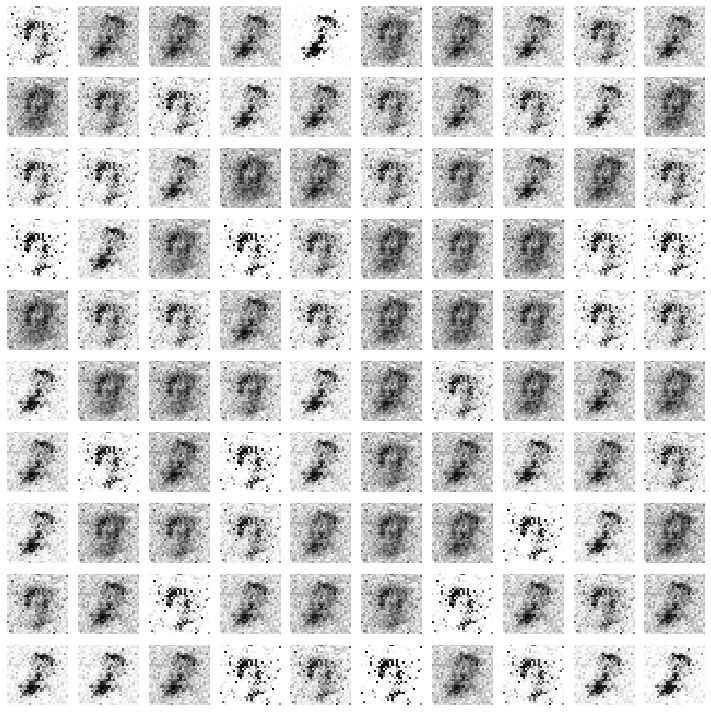

--------------- Epoch 2 ---------------


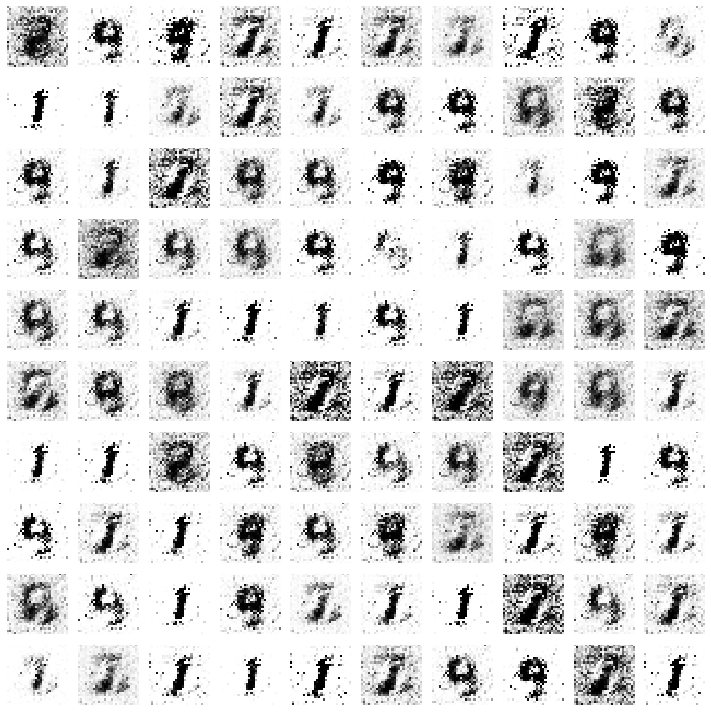

--------------- Epoch 3 ---------------


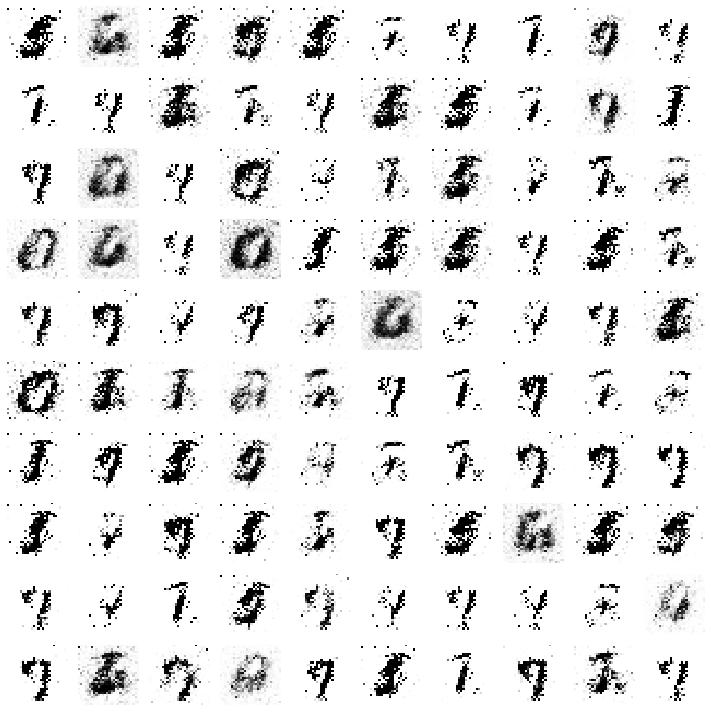

--------------- Epoch 4 ---------------


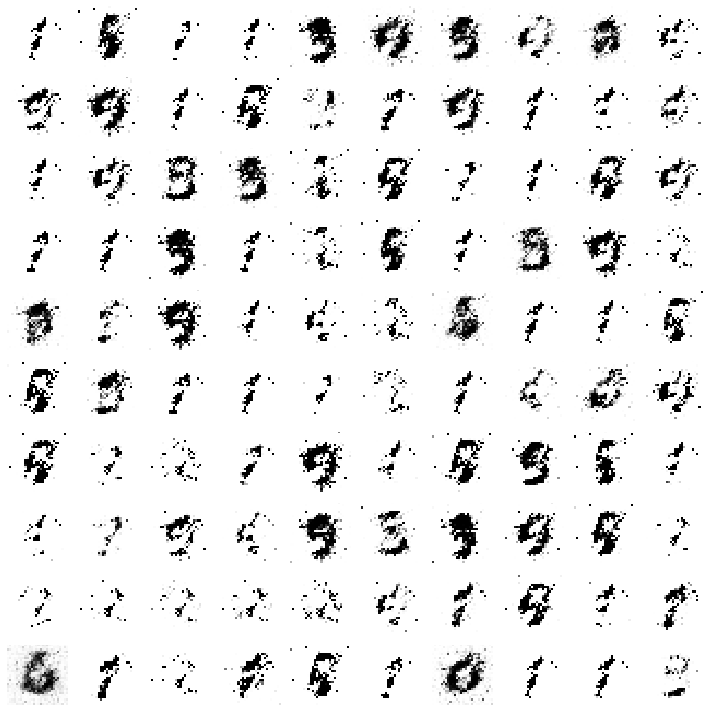

--------------- Epoch 5 ---------------


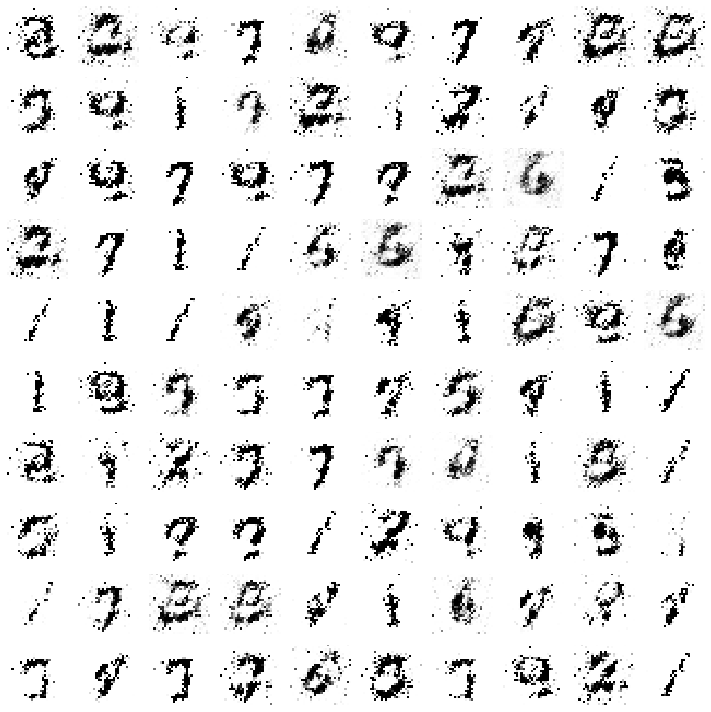

--------------- Epoch 6 ---------------


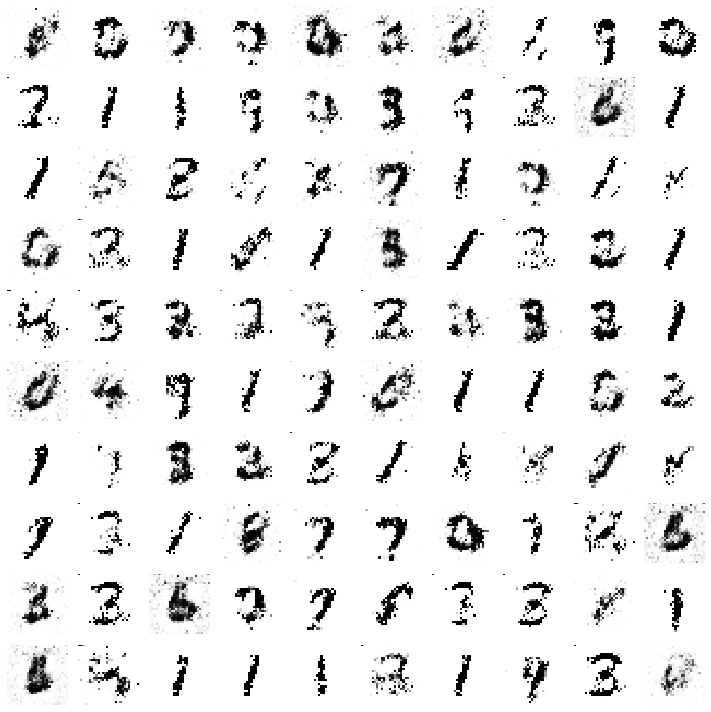

--------------- Epoch 7 ---------------


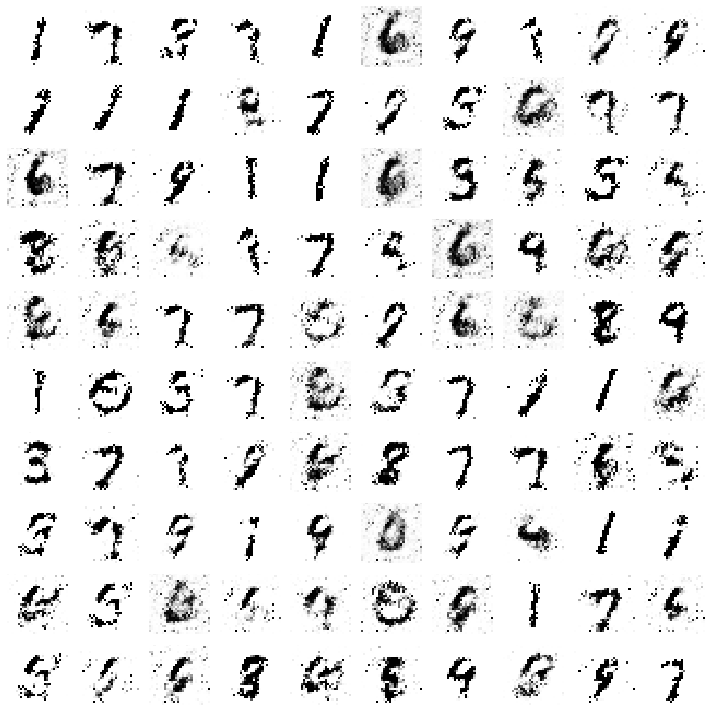

--------------- Epoch 8 ---------------


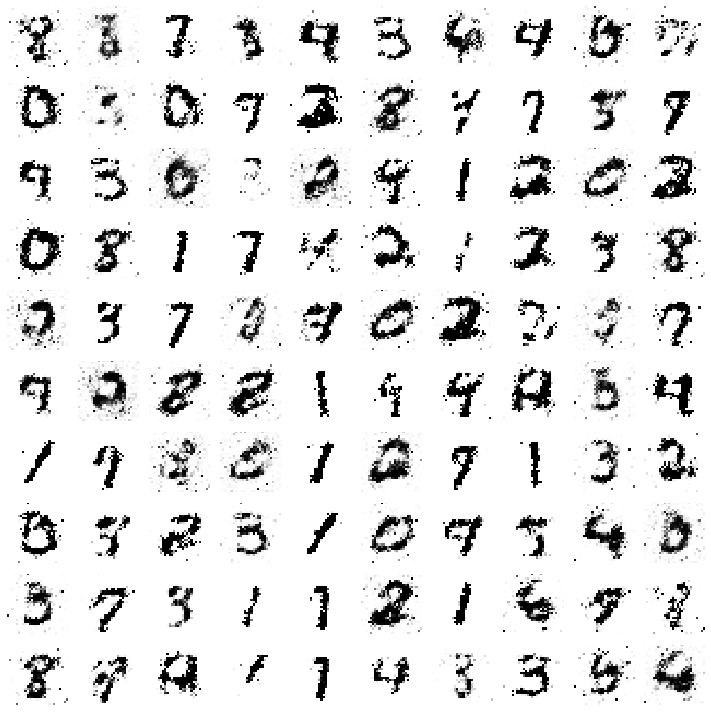

--------------- Epoch 9 ---------------


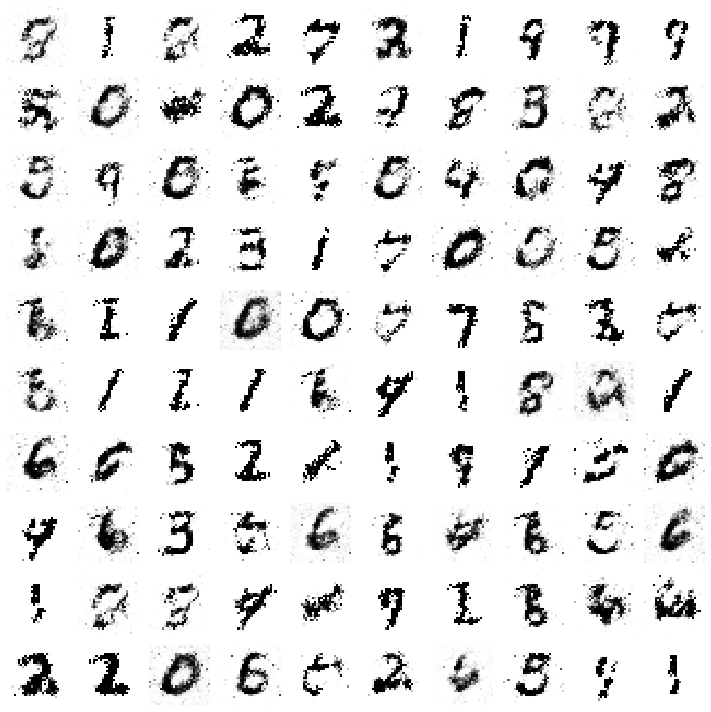

--------------- Epoch 10 ---------------


In [ ]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    images = G.predict(noise)
    images = images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def train(epochs=1, batch_size=128):
    batch_count = x_train.shape[0] / batch_size
    print( 'Epochs:', epochs )
    print( 'Batch size:', batch_size )
    print( 'Batches per epoch:', batch_count )

    for e in range(1, epochs+1):
        print( '-'*15, 'Epoch %d' % e, '-'*15 )
        for _ in range(int(batch_count)):
            # Train discriminator
            # TODO* 1.
            noise =np.random.normal(0,1, size=(batch_size, random_dim))
            
            # TODO* 2.
            real_images = x_train[np.random.randint(0,high=len(x_train),size=batch_size)]

            # TODO* 3. 
            generated_images = G.predict(noise)
            #print(generated_images.shape)
            #print(real_images.shape)

            # TODO* 4.
            images = np.concatenate([real_images, generated_images])

            # TODO* 5.
            labels =np.zeros((2*batch_size,1))
            labels[:batch_size]=0.9

            D.trainable = True
            # TODO* 6.
            D.train_on_batch(images, labels)

            # Train generator
            # TODO* 7.
            noise= np.random.normal(0,1, [batch_size, random_dim])
            
            # TODO* 8.
            labels = np.ones(batch_size)
            
            D.trainable = False
            # TODO* 9.
            gan.train_on_batch(noise, labels)


        # Plot some generated images
        plot_generated_images(e)


train(50, 128)

# 3. Conditional GAN (cGAN)

CGAN is a type of GAN that involves the conditional generation of images by a generator model. Image generation can be conditional on a class label, allowing the targeted generated of images of a given type.

TODO: implement a cGAN that can generate an image of a given class (you use the architecture in Figures 2, 3 in the pdf file)

## 3.1. Discriminator model
Starting with the discriminator model, a new second input is defined that takes an integer for the class label of the image. 

The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the MNIST dataset (0 through 9) will map to a different 50-element vector representation that will be learned by the discriminator model.

The output of the embedding is then passed to a fully connected layer with a linear activation. Importantly, the fully connected layer has enough outputs that can be reshaped into one channel of a 28×28 image. The activations are reshaped into single 28×28 activation map and concatenated with the input image. This has the effect of looking like a two-channel input image to the next convolutional layer.

- Look at the following codes to have an idea how you can implement the Discriminator.



In [ ]:
in_shape=(28, 28, 1)
n_classes=10
random_dim = 100


# label input
in_label = Input(shape=(1,))

# embedding for categorical input
li = Embedding(n_classes, 50)(in_label)

# scale up to image dimensions with linear activation
li = Dense(784)(li)

# reshape to additional channel
li = Reshape((28, 28, 1))(li)

# image input
in_image = Input(shape=in_shape)

# concat label as a channel
merge = Concatenate()([in_image, li])

le = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
le = LeakyReLU(alpha=0.2)(le)

le = Conv2D(128, (3,3), strides=(2,2), padding='same')(le)
le = LeakyReLU(alpha=0.2)(le)

le = Flatten()(le)

le = Dropout(0.5)(le)


# output
out_layer = Dense(1, activation='sigmoid')(le)

# define model
D = Model([in_image, in_label], out_layer)

# compile model
D.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# 3.2. Generator model
The generator model must be updated to take the class label. 

As in the discriminator, the class label is passed through an embedding layer to map it to a unique 50-element vector and is then passed through a fully connected layer with a linear activation before being resized. 
The outputs of the fully connected layer are resized into a single 7×7 feature map. This is to match the 7×7 feature map activations of the unconditional generator model. The new 7×7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the prior model.

- Look at the following codes to have an idea how you can implement the Generator model.


In [ ]:
#
latent_dim=100

# label input
in_label = Input(shape=(1,))

# embedding for categorical input
li = Embedding(n_classes, 50)(in_label)

# linear multiplication
n_nodes = 7 * 7
li = Dense(n_nodes)(li)

# reshape to additional channel
li = Reshape((7, 7, 1))(li)

# image generator input
in_lat = Input(shape=(random_dim,))

n_nodes = 128 * 7 * 7
gen = Dense(n_nodes)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((7, 7, 128))(gen)

# merge image gen and label input
merge = Concatenate()([gen, li])

gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
gen = LeakyReLU(alpha=0.2)(gen)
	
gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
 
# output
out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

# define model
modelG = Model([in_lat, in_label], out_layer)

